In [2]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

In [3]:
def sim_leverage(proxy, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    """
    Simulates a leverage ETF given its proxy, leverage, and expense ratio.

    Daily percent change is calculated by taking the daily percent change of
    the proxy, subtracting the daily expense ratio, then multiplying by the leverage.
    """
    pct_change = proxy.pct_change(1)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim = (1 + pct_change).cumprod() * initial_value
    sim[0] = initial_value
    return sim

In [4]:
start = datetime.datetime(1986, 5, 19)
end = datetime.datetime(2019, 1, 1)

vfinx = web.DataReader("VFINX", "yahoo", start, end)["Adj Close"]
vustx = web.DataReader("VUSTX", "yahoo", start, end)["Adj Close"]

upro_sim = sim_leverage(vfinx, leverage=3.0, expense_ratio=0.0092).to_frame("close")
tmf_sim = sim_leverage(vustx, leverage=3.0, expense_ratio=0.0109).to_frame("close")

In [5]:
for column in ["open", "high", "low"]:
    upro_sim[column] = upro_sim["close"]
    tmf_sim[column] = tmf_sim["close"]

upro_sim["volume"] = 0
tmf_sim["volume"] = 0

upro_sim = bt.feeds.PandasData(dataname=upro_sim)
tmf_sim = bt.feeds.PandasData(dataname=tmf_sim)
vfinx = bt.feeds.YahooFinanceData(dataname="VFINX", fromdate=start, todate=end)

In [6]:
class BuyAndHold(bt.Strategy):
    def next(self):
        if not self.getposition(self.data).size:
            self.order_target_percent(self.data, target=1.0)

In [7]:
def backtest(datas, strategy, plot=False, **kwargs):
    cerebro = bt.Cerebro()
    for data in datas:
        cerebro.adddata(data)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    results = cerebro.run()
    if plot:
        cerebro.plot()
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

<IPython.core.display.Javascript object>


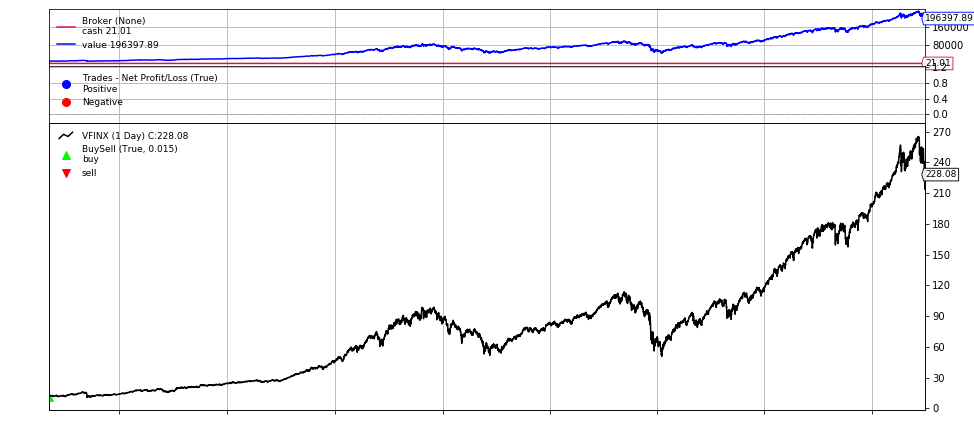

Max Drawdown: 55.24%
CAGR: 9.55%
Sharpe: 0.652


In [9]:
dd, cagr, sharpe = backtest([vfinx], BuyAndHold, plot=True)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

<IPython.core.display.Javascript object>


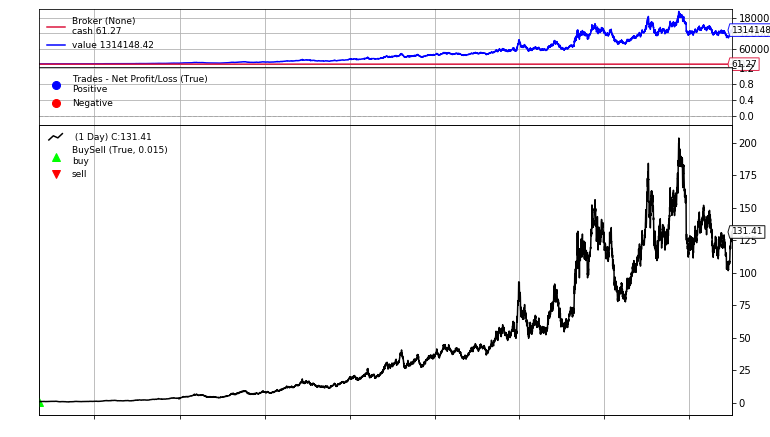

Max Drawdown: 97.11%
CAGR: 15.37%
Sharpe: 0.541


In [25]:
dd, cagr, sharpe = backtest([upro_sim], BuyAndHold, plot=True)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

In [26]:
dd, cagr, sharpe = backtest([tmf_sim], BuyAndHold, plot=True)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

Max Drawdown: 50.27%
CAGR: 16.12%
Sharpe: 0.575


In [12]:
class AssetAllocation(bt.Strategy):
    params = (
        ('equity',0.6),
    )
    def __init__(self):
        self.UPRO = self.datas[0]
        self.TMF = self.datas[1]
        self.counter = 0

    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.UPRO, target=self.params.equity)
            self.order_target_percent(self.TMF, target=(1 - self.params.equity))
        self.counter += 1

<IPython.core.display.Javascript object>


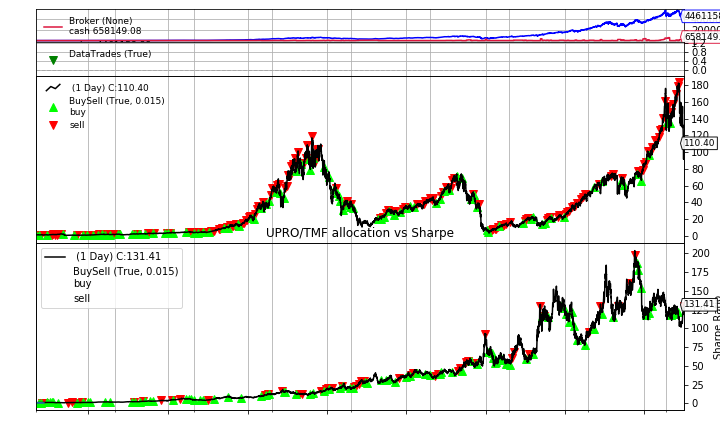

Max Drawdown: 63.11%
CAGR: 20.55%
Sharpe: 0.698


In [13]:
dd, cagr, sharpe = backtest([upro_sim, tmf_sim], AssetAllocation, plot=True, equity=0.6)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

In [14]:
sharpes = {}
for perc_equity in range(0, 101, 5):
    sharpes[perc_equity] = backtest([upro_sim, tmf_sim], AssetAllocation, equity=(perc_equity / 100.0))[2]

<IPython.core.display.Javascript object>


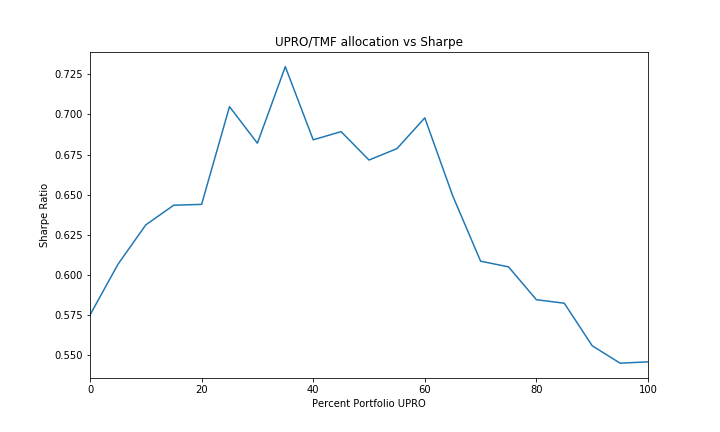

Max Sharpe of 0.730 at 35% UPRO


In [16]:
series = pd.Series(sharpes)
ax = series.plot(title="UPRO/TMF allocation vs Sharpe")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Percent Portfolio UPRO");
print(f"Max Sharpe of {series.max():.3f} at {series.idxmax()}% UPRO")

<IPython.core.display.Javascript object>


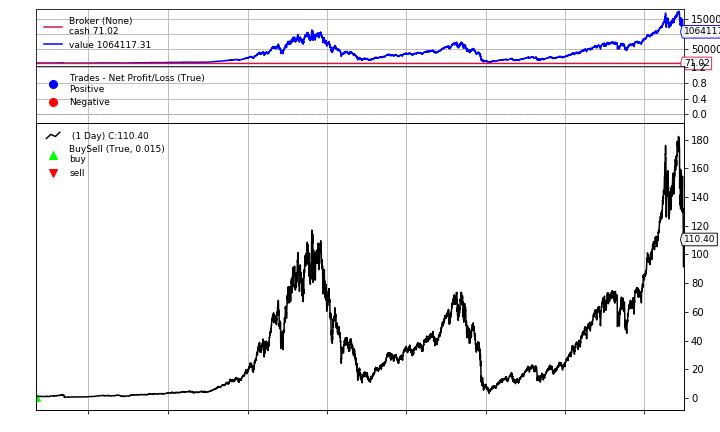

Max Drawdown: 39.25%
CAGR: 19.53%
Sharpe: 0.730


In [17]:
dd, cagr, sharpe = backtest([upro_sim, tmf_sim], AssetAllocation, plot=True, equity=0.35)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")